## Constructing machine learning potential

First of all we need to get some dataset for fitting. Good example
is [this one ](https://archive.materialscloud.org/record/2020.110):

In [1]:
# downloading dataset from https://archive.materialscloud.org/record/2020.110

!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz

--2022-11-01 16:20:48--  https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528
Resolving archive.materialscloud.org (archive.materialscloud.org)... 148.187.149.49
Connecting to archive.materialscloud.org (archive.materialscloud.org)|148.187.149.49|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Signature=LJUaGsQLl8CZKNZUJGpSH69ZX0g%3D&AWSAccessKeyId=f30fe0bddb114e91abe6adf3d36c6f2e&Expires=1667316108 [following]
--2022-11-01 16:20:48--  https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Signature=LJUaGsQLl8CZKNZUJGpSH69ZX0g%3D&AWSAccessKey

In [2]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge

In the following cell, parameters that control subsequent calculations, along with hyperparameters of the model, are defined. 


The total amount of structures in the methane dataset is huge. Thus it is a good idea to select a smaller amount of structures to speed up the calculations. 


Two out of the three steps of NICE require data to be fitted. In the PCA step, atomic environments are used to determine the matrix of a linear transformation, suitable for the preservation of the most amount of information for **this particular dataset**. In purifiers, eliminated correlations are also dataset-specific. Though, it is absolutely not necessary 
to use the same amount of data to fit the NICE transformer and to fit the subsequent machine learning model. Typically, the NICE transformer requires less amount of data to be fitted. In addition, the fitting process requires a noticeable amount of RAM. Thus, it is a good idea to restrict the amount of data for this step, which is controlled by **environments_for_fitting variable**. 

**grid** defines the set of numbers of training configurations for which error would be estimated in order to get an idea of the quality of the model, depending on the number of training configurations. 
(yep, the NICE transformer uses more data for fitting for a few first points, but it is just a tutorial)

In the HYPERS dictionary, parameters for initial spherical expansion are defined. For more detail, we refer the reader to [librascal](https://github.com/cosmo-epfl/librascal) documentation. 

In [3]:
HARTREE_TO_EV = 27.211386245988
train_subset = "0:10000"  #input for ase.io.read command
test_subset = "10000:15000"  #input to ase.io.read command
environments_for_fitting = 1000  #number of environments to fit nice transfomers
grid = [150, 200, 350, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500,
        10000]  #for learning curve

#HYPERS for librascal spherical expansion coefficients
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': 5,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}

This cell is the most important one. Our model is defined here. As was mentioned before,  
NICE is the sequence of standard transformations, where each increases the body order by 1. 
The classes which implement this logic are **StandardBlock** and **StandardSequence**. 

**StandardSequence** consist of 1) **initial scaler** 2) **initial pca** and of 3) sequence of **standard blocks**. 

Let's imagine uniform multiplication of spherical expansion coefficients by some constant k. In this case, covariants of order k would change as *= k ^(body order). In other words,  the relative scale of different body orders would change. This might affect subsequent regression, so it is a good idea to fix the scale in a proper way. This is done by **initial scaler**. It has two modes - "**signal integral**" and "**variance**". In the first case, it scales coefficients in such a way as to make the integral of the squared corresponding signal over the ball to be one. In the second case, it assures the variance of the coefficient's entries to be one. In practice, the first mode gives better results. The second parameter to this class is to scale coefficients individually, i. e. separately for each environment or globally, thus preserving information about the scale of signals in relation to each other. 

**Initial pca** is the same PCA that is applied in each block; more details about it later. It is the first transformation to coefficients after **initial scaler**. 

As already mentioned in theory, each block consists of two branches - for covariants and for invariants. Each branch consists of expansion, purification, and pca steps. During the expansion step in each block, features of the next body order are produced by Clebsch-Gordan iteration between features from the previous block and spherical expansion coefficients after **initial_pca**. In the case of full expansion (each with each), the number of features after the transformation would be incredibly huge, as it was already discussed in the theory section. Thus, the thresholding heuristic is used. For each feature, information on how important it is, is stored during the calculations. In standard sequence, these importances are just explained variance ratios after the PCA step. During expansion for each pair of covariant vectors, "pair importance" is defined as the multiplication of previously discussed single feature **importances**, and after that, only a fixed amount of the most important input pairs produce output. This fixed amount is controlled by **num_expand** parameter. If it is not specified (or set to **None**), full expansion (each with each) will be performed. 

The nature of the purifier step was discussed in the theory section. Parameter **max_take** controls the number of features to take for purification from previous body orders. (Features are always stored in descending order of importance, and it uses the first ones first). If **max_take** is not specified (**None**) it will use all available features. 
One additional parameter is a linear regressor to use. For example 

from sklearn.linear_model import Ridge<br>
CovariantsPurifierBoth(regressor = Ridge(alpha = 42, fit_intercept = False), max_take = 10)

or 

from sklearn.linear_model import Lars<br>
InvariantsPurifier(regressor = Lars(n_nonzero_coefs = 7), max_take = 10)

The default one is Ridge(alpha = 1e-12) without fitting intercept for covariants purifier and with fitting intercept for invariants purifier. 

***Important!*** always put **fit_intercept = False** to regressor in covariants purifier. Otherwise, the resulting features would not be covariants since the vector with constant entries is not covariant. (it is not checked automatically since the corresponding parameter might have a different name from "fit_intercept")

Custom regressors can be fed into purifiers. More details about it in the tutorial "Custom regressors into purifiers."

Parameter of PCA states for the number of output features. If it is not specified (None), full pca will be performed. 

"Both" in name of classes states the fact that transformations are done simultaneously on even and odd features (more details about it in the tutorials "Calculating covariants" (what are even and odd features?) and "Constructor or non-standard sequence" (classes to work with no separation?)). 

"Individual" in **IndividualLambdaPCAsBoth** stands for the fact that transformations are independent for each lambda channel.

Since we are interested only in invariants, it is not necessary for the last block to calculate covariants. Thus, the corresponding branch is filled with Nones.

In this example, parameters of covariant and invariant branches (such as **num_expand** in expansioners) are not dramatically different, but in real-life calculations they usually differ from each other dramatically (see examples folder). 


In [4]:
#our model:
def get_nice():
    return StandardSequence([
        StandardBlock(ThresholdExpansioner(num_expand=150),
                      CovariantsPurifierBoth(max_take=10),
                      IndividualLambdaPCAsBoth(n_components=50),
                      ThresholdExpansioner(num_expand=300, mode='invariants'),
                      InvariantsPurifier(max_take=50),
                      InvariantsPCA(n_components=200)),
        StandardBlock(ThresholdExpansioner(num_expand=150),
                      CovariantsPurifierBoth(max_take=10),
                      IndividualLambdaPCAsBoth(n_components=50),
                      ThresholdExpansioner(num_expand=300, mode='invariants'),
                      InvariantsPurifier(max_take=50),
                      InvariantsPCA(n_components=200)),
        StandardBlock(None, None, None,
                      ThresholdExpansioner(num_expand=300, mode='invariants'),
                      InvariantsPurifier(max_take=50),
                      InvariantsPCA(n_components=200))
    ],
                            initial_scaler=InitialScaler(
                                mode='signal integral', individually=True))

It is not necessary to always fill all the transformation steps. For example, the following block is valid:

<pre>
StandardBlock(ThresholdExpansioner(num_expand = 150),
              None, 
              IndividualLambdaPCAsBoth(n_components = 50), 
              ThresholdExpansioner(num_expand =300, mode = 'invariants'), 
              InvariantsPurifier(max_take = 50), 
              None)
</pre>   
  
In this case, purifying step in the covariants branch and the PCA step in the invariants branch would be omitted. Covariants and invariants branches are independent. In case of invalid  combinations, such as 

<pre>
StandardBlock(None, 
              None,
              IndividualLambdaPCAsBoth(n_components = 50), 
              ...)
</pre>              

It would raise a value error with the description of the problem during initialization.

All intermediate blocks must compute covariants. A block is considered to be computing covariants if it contains covariant expansion and covariant pca. The latter is required since expansioners in subsequent blocks require not only covariants themselves but also their **importances** for thresholding. 

In this cell, we read the structures, get a set of all the species in the dataset, and calculate the spherical expansion. 

**all_species** is a numpy array with ints, where 1 is H, 2 is He, and so on. 

**coefficients** is the dictionary where the keys are central species, 1 and 6 in our case, and entries are numpy arrays shaped in the **[environment_index, radial/specie index, l, m]** way. 

In [5]:
train_structures = ase.io.read('methane.extxyz', index=train_subset)

test_structures = ase.io.read('methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)
print("all species: ", all_species)
train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species)

all species:  [1 6]


100%|██████████| 2/2 [00:00<00:00, 39.62it/s]


We are going to fit two NICE transformers on environments around both the H and C atoms separately.
The following cells create them and perform the fitting: 

In [6]:
#individual nice transformers for each atomic specie in the dataset
nice = {}
for key in train_coefficients.keys():
    nice[key] = get_nice()

In [7]:
for key in train_coefficients.keys():
    nice[key].fit(train_coefficients[key][:environments_for_fitting])

/home/pozdn/.local/lib/python3.8/site-packages/nice/blocks/compressors.py:216: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  warnings.warn(("Amount of provided data is less "
/home/pozdn/.local/lib/python3.8/site-packages/nice/blocks/compressors.py:216: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  warnings.warn(("Amount of provided data is less "
/home/pozdn/.local/lib/python3.8/site-packages/nice/blocks/compressors.py:216: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 200, desired number of environments is 2000, actual number of environments is 1000.
  warnings.warn(("Amount of provided data is less "
/home/pozdn/.local/lib/python3.8/site-packages/ni

It is not necessary to fit different nice transformers for each central specie, see for example qm9 examples in example folder

Let's calculate representations!:

In [8]:
train_features = {}
for specie in all_species:
    train_features[specie] = nice[specie].transform(
        train_coefficients[specie], return_only_invariants=True)

test_features = {}
for specie in all_species:
    test_features[specie] = nice[specie].transform(test_coefficients[specie],
                                                   return_only_invariants=True)

The result is a nested dictionary. The first level keys are central species, and the inner level keys are body orders. Inside are **numpy arrays** with shapes **[environment_index, invariant_index]**:

In this case number of training structures is 10k, and each structure consists of 4 H atoms. Thus, the total number of H centered environments is 40k.

In [9]:
for key in train_features[1].keys():
    print("{} : {}".format(key, train_features[1][key].shape))

1 : (40000, 10)
2 : (40000, 200)
3 : (40000, 200)
4 : (40000, 200)


Now we need to prepare for subsequent linear regression. As was already discussed in the theory section, energy is an extensive property, and thus it is given as a sum of atomic contributions. 
Each atomic contribution depends on 1) the central specie and 2) the environment. Thus, it is straightforward to see that if each atomic contribution is given by a linear combination of previously calculated NICE features, the structural features should have the following form - for each structure, the set of features is a concatenation of representations for each specie. Representation for each specie is a sum of NICE representations over the atoms with this specie in the structure. 

In our case, the representation of each environment has a size of 200 + 200 + 200 + 10 = 610. And we have two atomic species - H and C. Thus, the shape of structural features should be **[number_of_structures, 610 * 2 = 1220]**:

In [10]:
train_features = make_structural_features(train_features, train_structures,
                                          all_species)
test_features = make_structural_features(test_features, test_structures,
                                         all_species)
print(train_features.shape)

100%|██████████| 5000/5000 [00:00<00:00, 17038.52it/s]

(10000, 1220)


Energies are a part of the dataset we previously downloaded:

In [11]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

And the last step is to do linear regression and plot learning curve.

In [12]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second)**2))


def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values))**2))


def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)


def estimate_performance(regressor, data_train, data_test, targets_train,
                         targets_test):
    regressor.fit(data_train, targets_train)
    return get_relative_performance(regressor.predict(data_test), targets_test)

In [13]:
errors = []
for el in tqdm.tqdm(grid):
    errors.append(
        estimate_performance(BayesianRidge(), train_features[:el],
                             test_features, train_energies[:el],
                             test_energies))

100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


In this smallest setup best rmse appeared to be about 7%:

In [14]:
print(errors)

[0.42468642019120245, 0.427996943106636, 0.3493202669393352, 0.23161547116525558, 0.18065414941207492, 0.16209085425017078, 0.1308818821205268, 0.11611936132988522, 0.09862824178668868, 0.08386888991766907, 0.07247065724235989, 0.0700226889461018]


The learning curve looks like this:

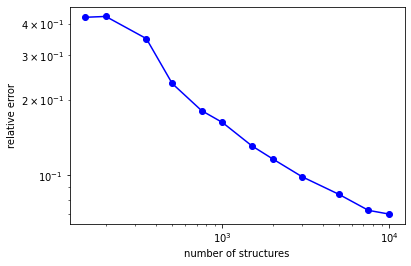

In [15]:
from matplotlib import pyplot as plt
plt.plot(grid, errors, 'bo')
plt.plot(grid, errors, 'b')
plt.xlabel("number of structures")
plt.ylabel("relative error")
plt.xscale('log')
plt.yscale('log')
plt.show()

The pipeline in this tutorial was designed to explain all the intermediate steps, but it has one drawback - at some moment, all atomic representations, along with all intermediate covariants for the whole dataset, are explicitly stored in RAM, which might become a bottleneck for big calculations. Indeed, only structural invariant features are eventually needed, and their size is much smaller than the size of all atomic representations, especially if the dataset consists of large molecules. Thus, it is a good idea to calculate structural features by small blocks and get rid of atomic representations for each block immediately. For this purpose, there is a function **nice.utilities.transform_sequentially**. It has a parameter **block_size** that controls the size of each chunk. The higher this chunk, the more RAM is required for calculations. But, on the other hand, for very small chunks, slow python loops over lambda channels with invoking separate python classes for each lambda channel might become a bottleneck (all the other indices are handled either by numpy vectorization or by cython loops). The other reason for the slowdown is multiprocessing. Thus, transforming time per single environment monotonically decrease with the **block_size** and eventually goes to saturation. The default value for **block_size** parameter should be fine in most cases.

The full example can be found in examples/methane_home_pc or in examples/qm9_home_pc. Other than that and the absence of markdown comments, these notebooks are almost identical to this tutorial (in qm9 single nice transformer is used for all central species). Thus, we recommend picking one of them as the code snippet. 